In [1]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"


In [2]:

import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.nn import functional as F
from functools import partial
from torch.autograd import Variable

/home/yanai-lab/xiong-p/.conda/envs/cu111/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.vgg16(pretrained=True,progress=True)
model.to(device)
softmax = nn.Softmax(dim=1)

/home/yanai-lab/xiong-p/.conda/envs/cu111/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yanai-lab/xiong-p/.conda/envs/cu111/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
img = cv2.imread("cat.jpg")
img_size = (256,256)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_trans = transforms.Compose([transforms.ToTensor(),transforms.Resize(img_size),norm])
img = img_trans(img)
img = img.unsqueeze(0)
img = img.to('cuda')
img.requires_grad = True

In [5]:
SYNSET_FILE='1000.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')
model.eval() 
with torch.no_grad(): 
    out=softmax(model(img)).cpu().numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.37115762 n02124075 Egyptian cat
[2] 0.20097692 n02123045 tabby, tabby cat
[3] 0.08672430 n02123159 tiger cat
[4] 0.04115677 n02127052 lynx, catamount
[5] 0.03951080 n02123597 Siamese cat, Siamese


In [6]:
dzdy =torch.zeros([1,1000]).to("cuda:0")
dzdy[0,top5idx[0]]=1
model(img).backward(dzdy)
out = abs(img.grad[0].cpu().numpy())
out = out.max(axis = 0)
maxv = out.max()
out = out/maxv

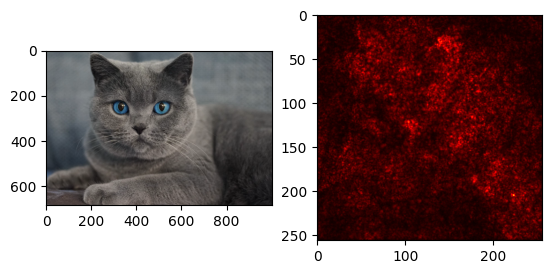

In [7]:
plt.subplot(121)
plt.imshow(cv2.imread("cat.jpg"))
plt.subplot(122)
plt.imshow(out,cmap="hot",interpolation="bicubic")
plt.show()